## 5. Analisador de Extremos Climáticos e Mudanças Climáticas
Crie um sistema robusto para análise de eventos extremos:

- Implemente análise de valores extremos usando distribuições GEV (Generalized Extreme Value)
- Calcule períodos de retorno para eventos como chuvas intensas, temperaturas extremas
- Analise tendências climáticas usando testes de Mann-Kendall e regressão Sen's slope
- Gere projeções de cenários futuros, mapas de risco e relatórios de adaptação climática

## Dependencias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import genextreme, norm
import warnings
warnings.filterwarnings('ignore')

## Mann Kendel - Biblioteca para analise climatica

In [2]:
try:
    from pymannkendall import original_test as mk_test
except:
    print("Instalando pymannkendall: pip install pymannkendall")
    # Implementação manual do teste Mann-Kendall
    def mk_test(data):
        n= len(data)
        s = 0
        for i in range(n-1):
            for j in range(i+1, n):
                if data[j]> data[i]:
                    s += 1
                elif data[j]< data[i]:
                    s -= 1
        
        var_s = n*(n-1)*(2*n+5)/18
        if s> 0:
            z = (s-1)/np.sqrt(var_s)
        elif s< 0:
            z = (s+1)/np.sqrt(var_s)
        else:
            z = 0
        p_value = 2*(1-stats.norm.cdf(abs(z)))
        trend = 'increasing' if z > 0 else 'decreasing' if z < 0 else 'no trend'

        class MKResult:
            def __init__(self, trend, p, z, s):
                self.trend = trend
                self.p = p
                self.z = z
                self.s = s
        return MKResult(trend, p_value, z, s)


## Classe Analisador de Eventos Climáticos

🌡️ SISTEMA DE ANÁLISE DE EXTREMOS CLIMÁTICOS

1️⃣ Inicializando analisador...

2️⃣ Carregando dados climáticos...
Dados sintéticos gerados com sucesso!
Dados carregados: 12418 registros
   📊 Período: 1990 - 2023
   📈 Total de registros: 12,418

📋 ESTATÍSTICAS BÁSICAS:
----------------------------------------
TEMPERATURE:
  Média: 21.07
  Desvio padrão: 7.70
  Mínimo: -0.19
  Máximo: 40.79

PRECIPITATION:
  Média: 1.93
  Desvio padrão: 9.33
  Mínimo: 0.00
  Máximo: 232.39


3️⃣ Executando análises detalhadas...

🔍 ANÁLISE 1: TEMPERATURE
--------------------------------------------------
   Extraindo valores extremos...
Extraídos 34 valores extremos usando método block_maxima
   Ajustando distribuição GEV...
Parâmetros GEV para temperature:
  Forma (ξ): 0.1474
  Localização (μ): 37.3220
  Escala (σ): 0.9521
  Teste KS: estatística = 0.0886, p-valor = 0.9311
   Analisando tendências (Mann-Kendall)...
Análise de tendência para temperature:
  Tendência: increasing
  Sen's slope: 0.056895 po

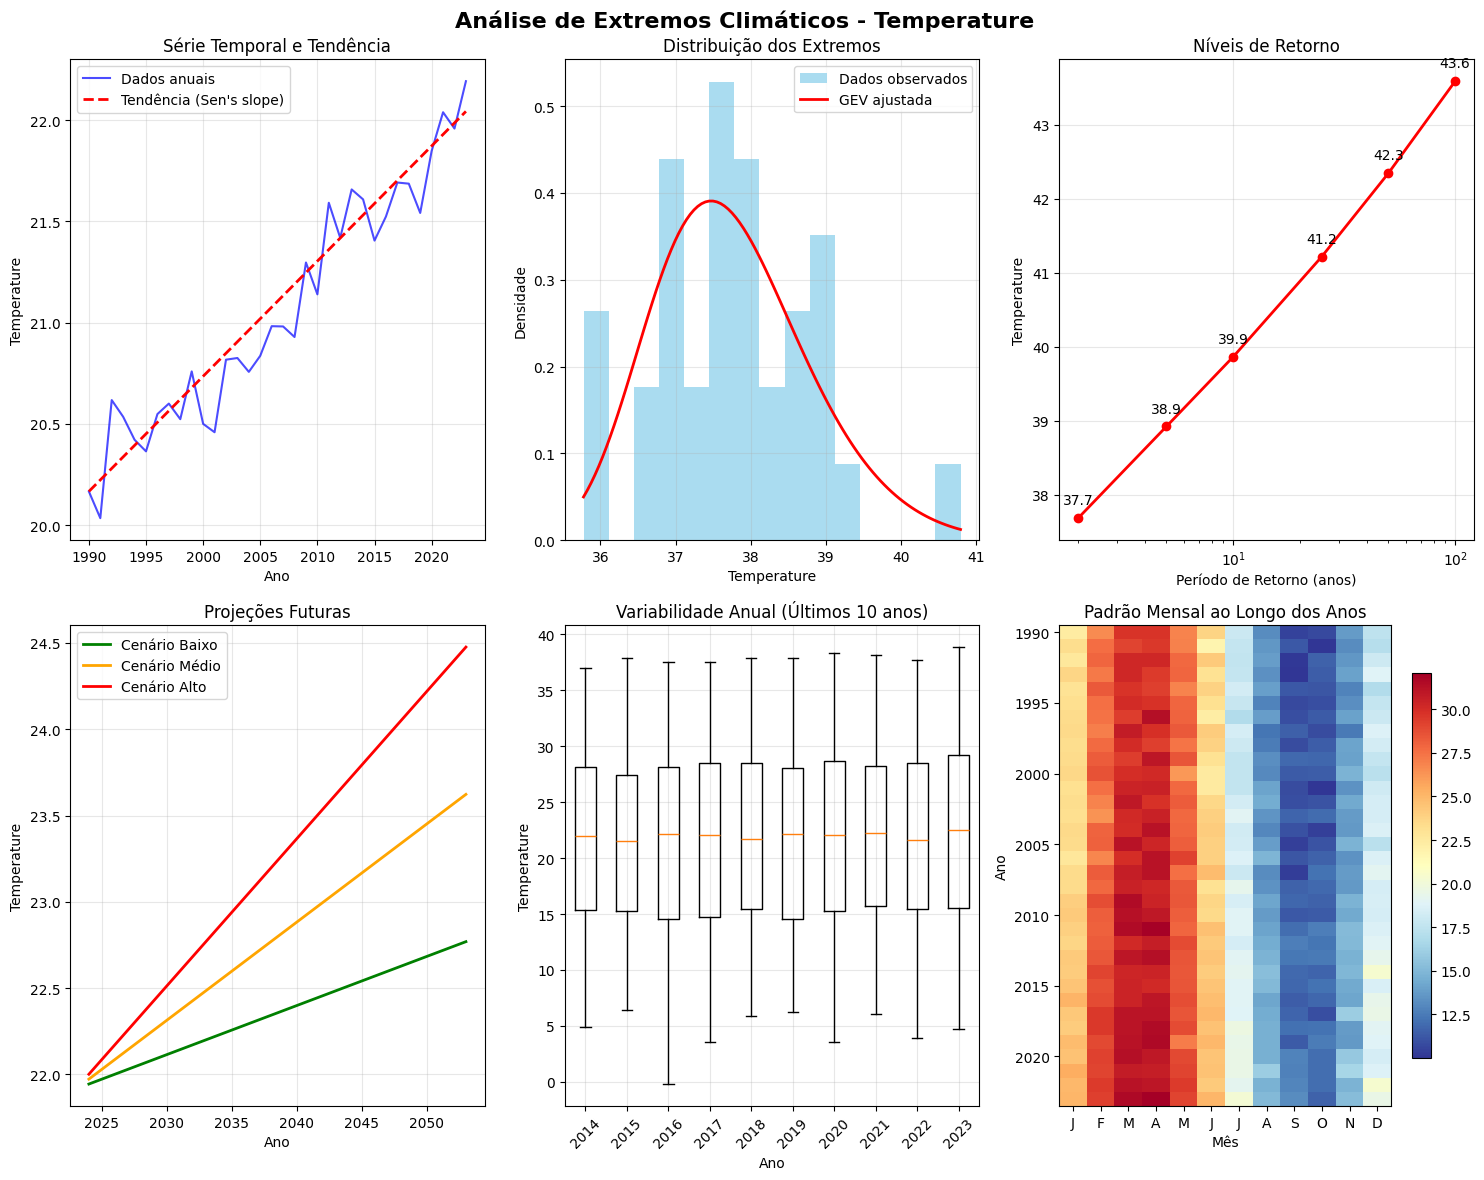


ANALISANDO: PRECIPITATION
Extraídos 34 valores extremos usando método block_maxima
Parâmetros GEV para precipitation:
  Forma (ξ): 0.2566
  Localização (μ): 101.6871
  Escala (σ): 51.0448
  Teste KS: estatística = 0.0970, p-valor = 0.8761
Análise de tendência para precipitation:
  Tendência: no trend
  Sen's slope: -0.001767 por ano
  Z-score: -0.2668
  P-valor: 0.789592
  Significativo (α=0.05): False


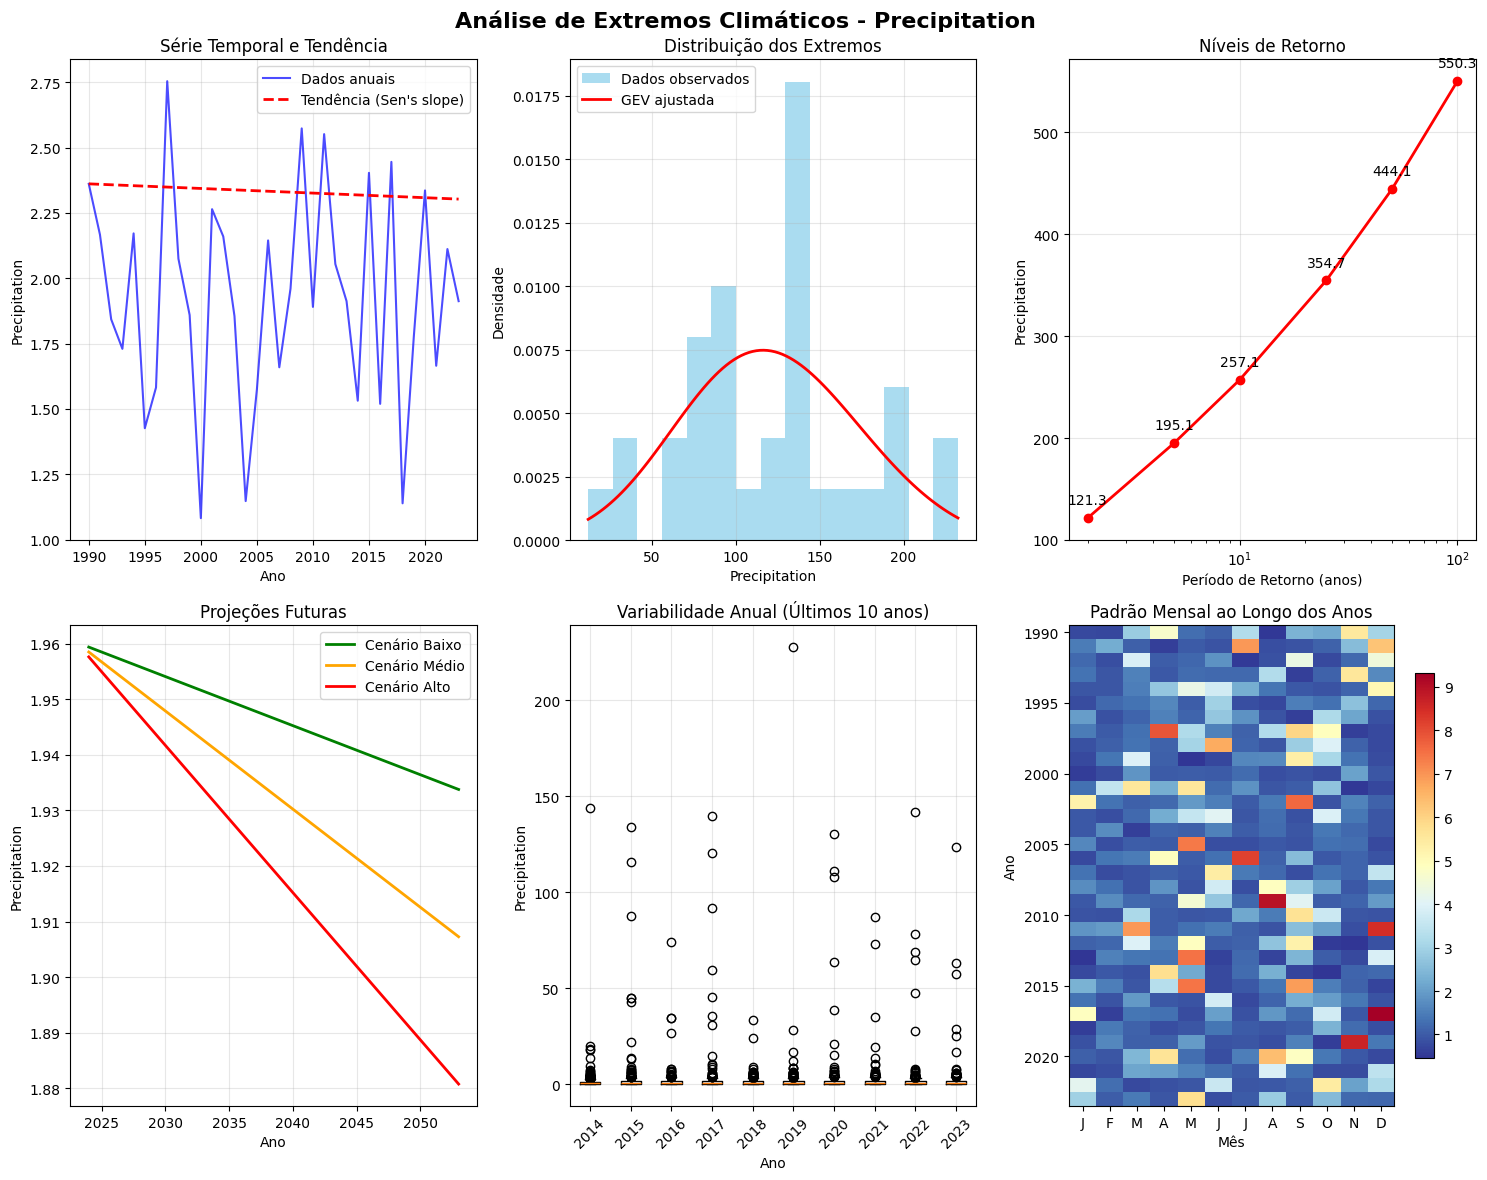


7️⃣ Exportando resultados...

Relatório exportado para analise_climatica_completa_summary.csv

RESUMO EXECUTIVO:
     Variable      Trend  Sen_Slope_per_year  Trend_Significant Trend_Risk Extreme_Risk  Return_50yr  Return_100yr
  temperature increasing            0.056895               True      Médio        Baixo    42.343370     43.587890
precipitation   no trend           -0.001767              False      Baixo        Baixo   444.133399    550.343876

📋 RESUMO EXECUTIVO FINAL

❌ ERRO durante a execução: 'year'
Verifique se todas as dependências estão instaladas:
pip install numpy pandas matplotlib seaborn scipy pymannkendall

🌍 Obrigado por usar o Analisador de Extremos Climáticos!
Para mais informações, consulte a documentação do código.


In [10]:
class ClimateExtremeAnalyzer:
    """
    Sistema robusto para análise de eventos extremos climáticos
    """
    
    def __init__(self):
        self.data = None
        self.extreme_data = None
        self.gev_params = {}
        self.trends = {}
        
    def load_data(self, data_path=None, data_df=None):
        """
        Carrega dados climáticos
        """
        if data_df is not None:
            self.data = data_df
        elif data_path:
            # Carregar de arquivo
            if data_path.endswith('.csv'):
                self.data = pd.read_csv(data_path, parse_dates=['date'])
            else:
                raise ValueError("Formato de arquivo não suportado")
        else:
            # Gerar dados sintéticos para demonstração
            self.generate_synthetic_data()
            
        print(f"Dados carregados: {len(self.data)} registros")
        return self.data
    
    def generate_synthetic_data(self):
        """
        Gera dados climáticos sintéticos para demonstração
        """
        np.random.seed(42)
        
        # Gerar 30 anos de dados diários
        dates = pd.date_range('1990-01-01', '2023-12-31', freq='D')
        n_days = len(dates)
        
        # Tendência de aquecimento
        trend = np.linspace(0, 2, n_days)  # Aumento de 2°C em 30 anos
        
        # Sazonalidade
        day_of_year = dates.dayofyear
        seasonal = 10 * np.sin(2 * np.pi * day_of_year / 365.25)
        
        # Temperatura base + tendência + sazonalidade + ruído
        temperature = 20 + trend + seasonal + np.random.normal(0, 3, n_days)
        
        # Eventos extremos ocasionais
        extreme_events = np.random.exponential(0.1, n_days) * np.random.choice([0, 1], n_days, p=[0.95, 0.05])
        temperature += extreme_events * 15
        
        # Precipitação (distribuição gamma)
        precipitation = np.random.gamma(0.5, 2, n_days)
        # Eventos extremos de chuva
        extreme_rain = np.random.choice([0, 1], n_days, p=[0.98, 0.02]) * np.random.exponential(50, n_days)
        precipitation += extreme_rain
        
        self.data = pd.DataFrame({
            'date': dates,
            'temperature': temperature,
            'precipitation': precipitation,
            'year': dates.year,
            'month': dates.month
        })
        
        print("Dados sintéticos gerados com sucesso!")
        
    def extract_extremes(self, variable='temperature', method='block_maxima', block_size='year'):
        """
        Extrai valores extremos usando diferentes métodos
        """
        if method == 'block_maxima':
            if block_size == 'year':
                extremes = self.data.groupby('year')[variable].max()
            elif block_size == 'month':
                extremes = self.data.groupby(['year', 'month'])[variable].max()
            else:
                raise ValueError("Block size deve ser 'year' ou 'month'")
                
        elif method == 'peaks_over_threshold':
            # Método POT (Peaks Over Threshold)
            threshold = np.percentile(self.data[variable], 95)  # Top 5%
            extremes = self.data[self.data[variable] > threshold][variable]
            
        self.extreme_data = extremes
        print(f"Extraídos {len(extremes)} valores extremos usando método {method}")
        return extremes
    
    def fit_gev_distribution(self, variable='temperature'):
        """
        Ajusta distribuição GEV (Generalized Extreme Value) aos dados extremos
        """
        if self.extreme_data is None:
            self.extract_extremes(variable)
        
        # Ajustar distribuição GEV
        gev_params = genextreme.fit(self.extreme_data)
        
        self.gev_params[variable] = {
            'shape': gev_params[0],    # parâmetro de forma (xi)
            'location': gev_params[1], # parâmetro de localização (mu)
            'scale': gev_params[2]     # parâmetro de escala (sigma)
        }
        
        # Teste de ajuste Kolmogorov-Smirnov
        ks_stat, ks_p_value = stats.kstest(self.extreme_data, 
                                          lambda x: genextreme.cdf(x, *gev_params))
        
        print(f"Parâmetros GEV para {variable}:")
        print(f"  Forma (ξ): {gev_params[0]:.4f}")
        print(f"  Localização (μ): {gev_params[1]:.4f}")
        print(f"  Escala (σ): {gev_params[2]:.4f}")
        print(f"  Teste KS: estatística = {ks_stat:.4f}, p-valor = {ks_p_value:.4f}")
        
        return gev_params
    
    def calculate_return_periods(self, variable='temperature', return_periods=[2, 5, 10, 25, 50, 100]):
        """
        Calcula períodos de retorno para diferentes níveis
        """
        if variable not in self.gev_params:
            self.fit_gev_distribution(variable)
        
        params = self.gev_params[variable]
        shape, loc, scale = params['shape'], params['location'], params['scale']
        
        return_levels = {}
        
        for T in return_periods:
            # Fórmula para período de retorno usando GEV
            if abs(shape) < 1e-6:  # Gumbel (shape ≈ 0)
                level = loc - scale * np.log(-np.log(1 - 1/T))
            else:  # GEV geral
                level = loc + (scale/shape) * ((-np.log(1 - 1/T))**(-shape) - 1)
            
            return_levels[T] = level
        
        return return_levels
    
    def mann_kendall_test(self, variable='temperature', alpha=0.05):
        """
        Realiza teste de Mann-Kendall para detectar tendências
        """
        annual_data = self.data.groupby('year')[variable].mean()
        
        # Teste Mann-Kendall
        mk_result = mk_test(annual_data.values)
        
        # Sen's slope (estimativa robusta da inclinação)
        n = len(annual_data)
        slopes = []
        
        for i in range(n-1):
            for j in range(i+1, n):
                slope = (annual_data.iloc[j] - annual_data.iloc[i]) / (j - i)
                slopes.append(slope)
        
        sens_slope = np.median(slopes)
        
        self.trends[variable] = {
            'trend': mk_result.trend,
            'p_value': mk_result.p,
            'z_score': mk_result.z,
            'sens_slope': sens_slope,
            'significant': mk_result.p < alpha
        }
        
        print(f"Análise de tendência para {variable}:")
        print(f"  Tendência: {mk_result.trend}")
        print(f"  Sen's slope: {sens_slope:.6f} por ano")
        print(f"  Z-score: {mk_result.z:.4f}")
        print(f"  P-valor: {mk_result.p:.6f}")
        print(f"  Significativo (α={alpha}): {mk_result.p < alpha}")
        
        return self.trends[variable]
    
    def project_future_scenarios(self, variable='temperature', future_years=30, scenarios=None):
        """
        Gera projeções de cenários futuros baseadas em tendências
        """
        if scenarios is None:
            scenarios = {
                'Baixo': 0.5,    # Fator de multiplicação da tendência atual
                'Médio': 1.0,    # Tendência atual mantida
                'Alto': 1.5      # Tendência acelerada
            }
        
        if variable not in self.trends:
            self.mann_kendall_test(variable)
        
        current_trend = self.trends[variable]['sens_slope']
        current_year = self.data['year'].max()
        future_years_range = range(current_year + 1, current_year + future_years + 1)
        
        # Valor base (média dos últimos 5 anos)
        base_value = self.data[self.data['year'] >= current_year - 4].groupby('year')[variable].mean().mean()
        
        projections = {}
        
        for scenario_name, factor in scenarios.items():
            yearly_change = current_trend * factor
            projection = []
            
            for i, year in enumerate(future_years_range):
                projected_value = base_value + (yearly_change * (i + 1))
                projection.append(projected_value)
            
            projections[scenario_name] = {
                'years': list(future_years_range),
                'values': projection
            }
        
        return projections
    
    def generate_risk_assessment(self, variable='temperature'):
        """
        Gera avaliação de risco baseada em extremos e tendências
        """
        # Calcular períodos de retorno
        return_levels = self.calculate_return_periods(variable)
        
        # Análise de tendência
        if variable not in self.trends:
            self.mann_kendall_test(variable)
        
        trend_info = self.trends[variable]
        
        # Classificação de risco
        if trend_info['significant']:
            if trend_info['sens_slope'] > 0:
                trend_risk = "Alto" if abs(trend_info['sens_slope']) > 0.1 else "Médio"
            else:
                trend_risk = "Baixo"
        else:
            trend_risk = "Baixo"
        
        # Risco de extremos baseado na variabilidade
        current_std = self.data.groupby('year')[variable].mean().std()
        if current_std > self.data[variable].std() * 0.8:
            extreme_risk = "Alto"
        elif current_std > self.data[variable].std() * 0.5:
            extreme_risk = "Médio"
        else:
            extreme_risk = "Baixo"
        
        risk_assessment = {
            'variable': variable,
            'trend_risk': trend_risk,
            'extreme_risk': extreme_risk,
            'return_levels': return_levels,
            'trend_info': trend_info,
            'recommendations': self._generate_recommendations(trend_risk, extreme_risk, variable)
        }
        
        return risk_assessment
    
    def _generate_recommendations(self, trend_risk, extreme_risk, variable):
        """
        Gera recomendações baseadas no nível de risco
        """
        recommendations = []
        
        if variable == 'temperature':
            if trend_risk == "Alto":
                recommendations.extend([
                    "Implementar sistemas de resfriamento eficientes",
                    "Desenvolver planos de adaptação ao calor extremo",
                    "Monitorar impactos na saúde pública"
                ])
            
            if extreme_risk == "Alto":
                recommendations.extend([
                    "Estabelecer sistemas de alerta precoce",
                    "Criar abrigos climatizados para população vulnerável",
                    "Revisar códigos de construção para resistir a temperaturas extremas"
                ])
        
        elif variable == 'precipitation':
            if trend_risk == "Alto":
                recommendations.extend([
                    "Melhorar sistemas de drenagem urbana",
                    "Implementar infraestrutura verde",
                    "Desenvolver reservatórios de contenção"
                ])
            
            if extreme_risk == "Alto":
                recommendations.extend([
                    "Criar sistemas de alerta de enchentes",
                    "Estabelecer rotas de evacuação",
                    "Implementar seguros contra desastres naturais"
                ])
        
        if not recommendations:
            recommendations.append("Manter monitoramento contínuo das condições climáticas")
        
        return recommendations
    
    def plot_extreme_analysis(self, variable='temperature', figsize=(15, 12)):
        """
        Cria visualizações abrangentes da análise de extremos
        """
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle(f'Análise de Extremos Climáticos - {variable.title()}', fontsize=16, fontweight='bold')
        
        # 1. Serie temporal com tendência
        ax1 = axes[0, 0]
        annual_data = self.data.groupby('year')[variable].mean()
        ax1.plot(annual_data.index, annual_data.values, 'b-', alpha=0.7, label='Dados anuais')
        
        # Linha de tendência
        if variable in self.trends:
            trend_line = self.trends[variable]['sens_slope'] * (annual_data.index - annual_data.index[0]) + annual_data.values[0]
            ax1.plot(annual_data.index, trend_line, 'r--', linewidth=2, label='Tendência (Sen\'s slope)')
        
        ax1.set_title('Série Temporal e Tendência')
        ax1.set_xlabel('Ano')
        ax1.set_ylabel(variable.title())
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Distribuição dos extremos
        ax2 = axes[0, 1]
        if self.extreme_data is not None:
            ax2.hist(self.extreme_data, bins=15, density=True, alpha=0.7, color='skyblue', label='Dados observados')
            
            # Ajuste GEV
            if variable in self.gev_params:
                params = self.gev_params[variable]
                x_range = np.linspace(self.extreme_data.min(), self.extreme_data.max(), 100)
                gev_pdf = genextreme.pdf(x_range, params['shape'], 
                                       loc=params['location'], scale=params['scale'])
                ax2.plot(x_range, gev_pdf, 'r-', linewidth=2, label='GEV ajustada')
        
        ax2.set_title('Distribuição dos Extremos')
        ax2.set_xlabel(variable.title())
        ax2.set_ylabel('Densidade')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Períodos de retorno
        ax3 = axes[0, 2]
        return_levels = self.calculate_return_periods(variable)
        periods = list(return_levels.keys())
        levels = list(return_levels.values())
        
        ax3.semilogx(periods, levels, 'ro-', linewidth=2, markersize=6)
        ax3.set_title('Níveis de Retorno')
        ax3.set_xlabel('Período de Retorno (anos)')
        ax3.set_ylabel(f'{variable.title()}')
        ax3.grid(True, alpha=0.3)
        
        # Adicionar valores nos pontos
        for i, (period, level) in enumerate(zip(periods, levels)):
            ax3.annotate(f'{level:.1f}', (period, level), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        # 4. Projeções futuras
        ax4 = axes[1, 0]
        projections = self.project_future_scenarios(variable)
        
        colors = ['green', 'orange', 'red']
        for i, (scenario, data) in enumerate(projections.items()):
            ax4.plot(data['years'], data['values'], 
                    color=colors[i], linewidth=2, label=f'Cenário {scenario}')
        
        ax4.set_title('Projeções Futuras')
        ax4.set_xlabel('Ano')
        ax4.set_ylabel(variable.title())
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Boxplot anual para mostrar variabilidade
        ax5 = axes[1, 1]
        years_to_show = self.data['year'].unique()[-10:]  # Últimos 10 anos
        data_subset = self.data[self.data['year'].isin(years_to_show)]
        
        box_data = [data_subset[data_subset['year'] == year][variable].values 
                   for year in years_to_show]
        
        ax5.boxplot(box_data, labels=years_to_show)
        ax5.set_title('Variabilidade Anual (Últimos 10 anos)')
        ax5.set_xlabel('Ano')
        ax5.set_ylabel(variable.title())
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)
        
        # 6. Mapa de calor mensal
        ax6 = axes[1, 2]
        monthly_avg = self.data.groupby(['year', 'month'])[variable].mean().reset_index()
        monthly_pivot = monthly_avg.pivot(index='year', columns='month', values=variable)
        
        im = ax6.imshow(monthly_pivot.values, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
        ax6.set_title('Padrão Mensal ao Longo dos Anos')
        ax6.set_xlabel('Mês')
        ax6.set_ylabel('Ano')
        
        # Configurar ticks
        ax6.set_xticks(range(12))
        ax6.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        
        years = monthly_pivot.index
        ax6.set_yticks(range(0, len(years), 5))
        ax6.set_yticklabels(years[::5])
        
        # Colorbar
        plt.colorbar(im, ax=ax6, shrink=0.8)
        
        plt.tight_layout()
        plt.show()
    
    def generate_climate_report(self, variables=['temperature', 'precipitation']):
        """
        Gera relatório completo de análise climática
        """
        report = {
            'data_period': f"{self.data['year'].min()} - {self.data['year'].max()}",
            'total_records': len(self.data),
            'variables_analyzed': variables,
            'analyses': {}
        }
        
        for variable in variables:
            print(f"\n{'='*50}")
            print(f"ANALISANDO: {variable.upper()}")
            print(f"{'='*50}")
            
            # Extrair extremos e ajustar GEV
            self.extract_extremes(variable)
            self.fit_gev_distribution(variable)
            
            # Análise de tendência
            trend_result = self.mann_kendall_test(variable)
            
            # Períodos de retorno
            return_levels = self.calculate_return_periods(variable)
            
            # Projeções futuras
            projections = self.project_future_scenarios(variable)
            
            # Avaliação de risco
            risk_assessment = self.generate_risk_assessment(variable)
            
            # Armazenar resultados
            report['analyses'][variable] = {
                'gev_parameters': self.gev_params[variable],
                'trend_analysis': trend_result,
                'return_levels': return_levels,
                'future_projections': projections,
                'risk_assessment': risk_assessment
            }
            
            # Gerar gráficos
            self.plot_extreme_analysis(variable)
        
        return report
    
    def export_results(self, report, filename='climate_analysis_report'):
        """
        Exporta resultados para arquivo
        """
        # Criar DataFrame com resumo dos resultados
        summary_data = []
        
        for variable, analysis in report['analyses'].items():
            trend = analysis['trend_analysis']
            risk = analysis['risk_assessment']
            
            summary_data.append({
                'Variable': variable,
                'Trend': trend['trend'],
                'Sen_Slope_per_year': trend['sens_slope'],
                'Trend_Significant': trend['significant'],
                'Trend_Risk': risk['trend_risk'],
                'Extreme_Risk': risk['extreme_risk'],
                'Return_50yr': analysis['return_levels'][50],
                'Return_100yr': analysis['return_levels'][100]
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f'{filename}_summary.csv', index=False)
        
        print(f"\nRelatório exportado para {filename}_summary.csv")
        print("\nRESUMO EXECUTIVO:")
        print(summary_df.to_string(index=False))


# Exemplo de uso e demonstração completa
if __name__ == "__main__":
    print("🌡️ SISTEMA DE ANÁLISE DE EXTREMOS CLIMÁTICOS")
    print("=" * 60)
    
    try:
        # Criar analisador
        print("\n1️⃣ Inicializando analisador...")
        analyzer = ClimateExtremeAnalyzer()
        
        # Carregar dados (sintéticos para demonstração)
        print("\n2️⃣ Carregando dados climáticos...")
        data = analyzer.load_data()
        print(f"   📊 Período: {data['year'].min()} - {data['year'].max()}")
        print(f"   📈 Total de registros: {len(data):,}")
        
        # Mostrar estatísticas básicas
        print("\n📋 ESTATÍSTICAS BÁSICAS:")
        print("-" * 40)
        for var in ['temperature', 'precipitation']:
            mean_val = data[var].mean()
            std_val = data[var].std()
            min_val = data[var].min()
            max_val = data[var].max()
            print(f"{var.upper()}:")
            print(f"  Média: {mean_val:.2f}")
            print(f"  Desvio padrão: {std_val:.2f}")
            print(f"  Mínimo: {min_val:.2f}")
            print(f"  Máximo: {max_val:.2f}")
            print()
        
        # Análise individual por variável
        print("\n3️⃣ Executando análises detalhadas...")
        
        variables_to_analyze = ['temperature', 'precipitation']
        results_summary = {}
        
        for i, variable in enumerate(variables_to_analyze, 1):
            print(f"\n🔍 ANÁLISE {i}: {variable.upper()}")
            print("-" * 50)
            
            # Extrair extremos
            print(f"   Extraindo valores extremos...")
            extremes = analyzer.extract_extremes(variable, method='block_maxima')
            
            # Ajustar distribuição GEV
            print(f"   Ajustando distribuição GEV...")
            gev_params = analyzer.fit_gev_distribution(variable)
            
            # Análise de tendências
            print(f"   Analisando tendências (Mann-Kendall)...")
            trend_result = analyzer.mann_kendall_test(variable)
            
            # Calcular períodos de retorno
            print(f"   Calculando períodos de retorno...")
            return_levels = analyzer.calculate_return_periods(variable)
            
            # Mostrar alguns resultados importantes
            print(f"\n   📊 RESULTADOS PRINCIPAIS:")
            print(f"   • Tendência: {trend_result['trend']}")
            print(f"   • Sen's slope: {trend_result['sens_slope']:.6f}/ano")
            print(f"   • Significativo: {'Sim' if trend_result['significant'] else 'Não'}")
            print(f"   • Nível 50 anos: {return_levels[50]:.2f}")
            print(f"   • Nível 100 anos: {return_levels[100]:.2f}")
            
            results_summary[variable] = {
                'trend': trend_result['trend'],
                'slope': trend_result['sens_slope'],
                'significant': trend_result['significant'],
                'return_50': return_levels[50],
                'return_100': return_levels[100]
            }
        
        # Projeções futuras
        print(f"\n4️⃣ Gerando projeções futuras...")
        for variable in variables_to_analyze:
            projections = analyzer.project_future_scenarios(variable, future_years=30)
            print(f"\n📈 PROJEÇÕES PARA {variable.upper()} (2054):")
            for scenario, data in projections.items():
                final_value = data['values'][-1]
                print(f"   • Cenário {scenario}: {final_value:.2f}")
        
        # Avaliação de risco
        print(f"\n5️⃣ Avaliação de riscos...")
        risk_summary = {}
        for variable in variables_to_analyze:
            risk_assessment = analyzer.generate_risk_assessment(variable)
            risk_summary[variable] = risk_assessment
            print(f"\n⚠️  RISCO - {variable.upper()}:")
            print(f"   • Risco de tendência: {risk_assessment['trend_risk']}")
            print(f"   • Risco de extremos: {risk_assessment['extreme_risk']}")
        
        # Gerar relatório completo
        print(f"\n6️⃣ Gerando relatório completo...")
        report = analyzer.generate_climate_report(variables_to_analyze)
        
        # Exportar resultados
        print(f"\n7️⃣ Exportando resultados...")
        analyzer.export_results(report, 'analise_climatica_completa')
        
        # Resumo executivo final
        print("\n" + "=" * 60)
        print("📋 RESUMO EXECUTIVO FINAL")
        print("=" * 60)
        
        print(f"\n🎯 PERÍODO ANALISADO: {data['year'].min()} - {data['year'].max()}")
        print(f"📊 TOTAL DE DADOS: {len(data):,} registros")
        
        print(f"\n🌡️ TEMPERATURA:")
        temp_results = results_summary['temperature']
        print(f"   • Tendência: {temp_results['trend']} ({temp_results['slope']:.4f}°C/ano)")
        print(f"   • Estatisticamente significativo: {'Sim' if temp_results['significant'] else 'Não'}")
        print(f"   • Temperatura extrema esperada a cada 50 anos: {temp_results['return_50']:.1f}°C")
        print(f"   • Temperatura extrema esperada a cada 100 anos: {temp_results['return_100']:.1f}°C")
        
        print(f"\n🌧️ PRECIPITAÇÃO:")
        prec_results = results_summary['precipitation']
        print(f"   • Tendência: {prec_results['trend']} ({prec_results['slope']:.4f} mm/ano)")
        print(f"   • Estatisticamente significativo: {'Sim' if prec_results['significant'] else 'Não'}")
        print(f"   • Precipitação extrema esperada a cada 50 anos: {prec_results['return_50']:.1f} mm")
        print(f"   • Precipitação extrema esperada a cada 100 anos: {prec_results['return_100']:.1f} mm")
        
        print(f"\n⚠️ NÍVEIS DE RISCO:")
        for variable, risk in risk_summary.items():
            print(f"   {variable.upper()}:")
            print(f"     - Risco de tendência: {risk['trend_risk']}")
            print(f"     - Risco de extremos: {risk['extreme_risk']}")
        
        print(f"\n💡 RECOMENDAÇÕES PRINCIPAIS:")
        all_recommendations = set()
        for variable, risk in risk_summary.items():
            for rec in risk['recommendations']:
                all_recommendations.add(rec)
        
        for i, rec in enumerate(sorted(all_recommendations), 1):
            print(f"   {i}. {rec}")
        
        print(f"\n✅ ANÁLISE COMPLETA FINALIZADA COM SUCESSO!")
        print(f"📄 Relatório detalhado salvo em: 'analise_climatica_completa_summary.csv'")
        print("🎨 Gráficos de análise foram gerados e exibidos.")
        
    except Exception as e:
        print(f"\n❌ ERRO durante a execução: {str(e)}")
        print("Verifique se todas as dependências estão instaladas:")
        print("pip install numpy pandas matplotlib seaborn scipy pymannkendall")
        
    finally:
        print(f"\n{'='*60}")
        print("🌍 Obrigado por usar o Analisador de Extremos Climáticos!")
        print("Para mais informações, consulte a documentação do código.")
        print("="*60)